Using device: cuda


Loading MATLAB data: 100%|██████████| 1000/1000 [00:01<00:00, 937.67it/s]
C:\Users\kazuya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch 1, Loss: 23.6975
Epoch 2, Loss: 1.1341
Epoch 3, Loss: 0.5075
Epoch 4, Loss: 0.6348
Epoch 5, Loss: 0.6555
Epoch 6, Loss: 0.1987
Epoch 7, Loss: 0.1538
Epoch 8, Loss: 0.2407
Epoch 9, Loss: 0.1451
Epoch 10, Loss: 0.1228
Epoch 11, Loss: 0.1698
Epoch 12, Loss: 0.1391
Epoch 13, Loss: 0.0793
Epoch 14, Loss: 0.0840
Epoch 15, Loss: 0.0887
Epoch 16, Loss: 0.0793
Epoch 17, Loss: 0.0849
Epoch 18, Loss: 0.0672
Epoch 19, Loss: 0.0752
Epoch 20, Loss: 0.0585
Epoch 21, Loss: 0.0631
Epoch 22, Loss: 0.0489
Epoch 23, Loss: 0.0513
Epoch 24, Loss: 0.0400
Epoch 25, Loss: 0.0406
Epoch 26, Loss: 0.0380
Epoch 27, Loss: 0.0343
Epoch 28, Loss: 0.0344
Epoch 29, Loss: 0.0310
Epoch 30, Loss: 0.0323
Epoch 31, Loss: 0.0291
Epoch 32, Loss: 0.0277
Epoch 33, Loss: 0.0285
Epoch 34, Loss: 0.0277
Epoch 35, Loss: 0.0243
Epoch 36, Loss: 0.0248
Epoch 37, Loss: 0.0230
Epoch 38, Loss: 0.0218
Epoch 39, Loss: 0.0200
Epoch 40, Loss: 0.0204
Epoch 41, Loss: 0.0204
Epoch 42, Loss: 0.0202
Epoch 43, Loss: 0.0191
Epoch 44, Loss: 0.0

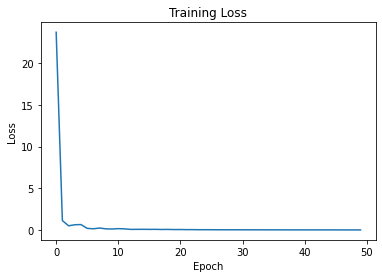

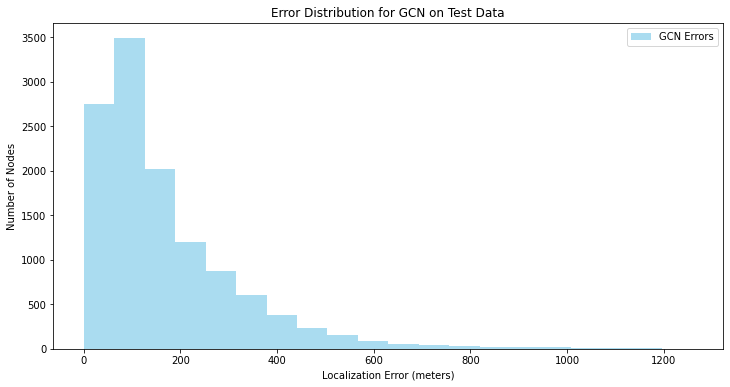

GCN Mean Error: 169.6934 m, Median Error: 120.4485 m


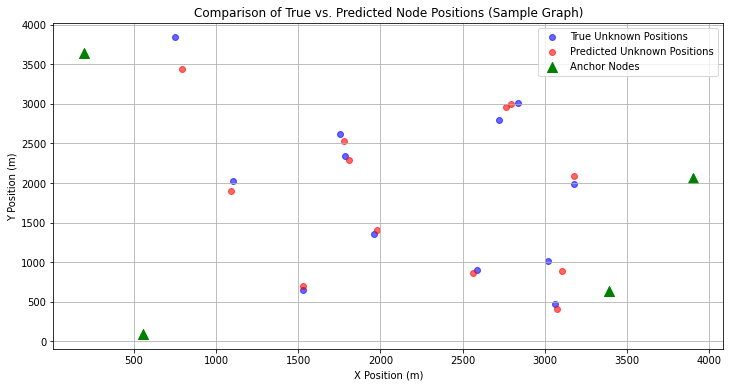

In [10]:
import torch
import numpy as np
from scipy.io import loadmat
from torch_geometric.data import Data, DataLoader
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from geopy.distance import geodesic
from torch.nn import Sequential, Linear, ReLU
from torch_geometric.nn import NNConv
import torch.nn.functional as F
from tqdm import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

#######################################
# Parameters and Utility Functions
#######################################
num_instances = 1000
num_anchors = 4    # Number of anchor nodes
num_unknowns = 12  # Number of unknown nodes
num_measurements = 10

# Origin from MATLAB code
mapOriginLat = 40.466198
mapOriginLon = 33.898610
earthRadius = 6378137.0
metersPerDegreeLat = (np.pi / 180) * earthRadius
metersPerDegreeLon = (np.pi / 180) * earthRadius * np.cos(np.deg2rad(mapOriginLat))

def latlon_to_xy(lat, lon, originLat, originLon):
    x = (lon - originLon) * metersPerDegreeLon
    y = (lat - originLat) * metersPerDegreeLat
    return x, y

#######################################
# Data Loading and Preparation
#######################################
data_list = []
for instance_idx in tqdm(range(1, num_instances + 1), desc="Loading MATLAB data"):
    filename = f"matlab/data/mid_16beacons_free/data_instance_{instance_idx}.mat"
    mat_data = loadmat(filename)

    nodeLatitudes = mat_data['nodeLatitudes'].flatten()
    nodeLongitudes = mat_data['nodeLongitudes'].flatten()
    signal_strength_matrix = mat_data['signal_strength_matrix']

    num_nodes = len(nodeLatitudes)
    node_x = np.zeros(num_nodes)
    node_y = np.zeros(num_nodes)
    for i in range(num_nodes):
        node_x[i], node_y[i] = latlon_to_xy(nodeLatitudes[i], nodeLongitudes[i], mapOriginLat, mapOriginLon)

    # Construct edges
    edge_index_list = []
    edge_attr_list = []
    for i in range(num_nodes):
        for j in range(num_nodes):
            if i != j and not np.isnan(signal_strength_matrix[i, j, 0]):
                edge_index_list.append([i, j])
                edge_attr_list.append(signal_strength_matrix[i, j, :])  # Use all RSSI measurements

    edge_index = torch.tensor(edge_index_list, dtype=torch.long).t().contiguous()
    edge_attr = torch.tensor(edge_attr_list, dtype=torch.float)

    # Identify anchors and unknowns
    anchor_mask = torch.zeros(num_nodes, dtype=torch.bool)
    anchor_mask[:num_anchors] = True
    unknown_mask = ~anchor_mask

    # Compute average anchor position for better initialization of unknowns
    avg_anchor_x = node_x[anchor_mask].mean()
    avg_anchor_y = node_y[anchor_mask].mean()

    # Node features: [x, y, is_anchor]
    # Anchors: true position
    # Unknown: start near the average anchor location
    node_features = []
    for i in range(num_nodes):
        is_anchor = 1 if i < num_anchors else 0
        if is_anchor:
            node_features.append([node_x[i], node_y[i], is_anchor])
        else:
            # Initialize unknowns near average anchor location
            # Add small random noise so they are not all identical
            node_features.append([avg_anchor_x + np.random.randn()*10,
                                  avg_anchor_y + np.random.randn()*10,
                                  is_anchor])

    x = torch.tensor(node_features, dtype=torch.float)
    y = torch.tensor(np.column_stack((node_x, node_y)), dtype=torch.float)

    data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=y)
    data.anchor_mask = anchor_mask
    data.unknown_mask = unknown_mask
    data_list.append(data)

#######################################
# Scaling Features and Targets
#######################################
# Scale node features
all_features = torch.cat([d.x for d in data_list], dim=0).numpy()
feature_scaler = StandardScaler()
feature_scaler.fit(all_features)
for d in data_list:
    d.x = torch.tensor(feature_scaler.transform(d.x.numpy()), dtype=torch.float)

# Scale targets (y positions)
all_y = torch.cat([d.y for d in data_list], dim=0).numpy()
y_scaler = StandardScaler()
y_scaler.fit(all_y)
for d in data_list:
    d.y = torch.tensor(y_scaler.transform(d.y.numpy()), dtype=torch.float)

train_loader = DataLoader(data_list, batch_size=2, shuffle=True)

#######################################
# Define GNN Model with NNConv
#######################################
class EdgeNet(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(EdgeNet, self).__init__()
        self.mlp = Sequential(
            Linear(in_channels, 64),
            ReLU(),
            Linear(64, out_channels)
        )
    def forward(self, x):
        return self.mlp(x)

class GNNWithEdgeAttr(torch.nn.Module):
    def __init__(self, node_in_dim, edge_in_dim, hidden_dim, output_dim):
        super(GNNWithEdgeAttr, self).__init__()
        self.edge_nn1 = EdgeNet(edge_in_dim, node_in_dim * hidden_dim)
        self.conv1 = NNConv(node_in_dim, hidden_dim, self.edge_nn1, aggr='mean')

        self.edge_nn2 = EdgeNet(edge_in_dim, hidden_dim * hidden_dim)
        self.conv2 = NNConv(hidden_dim, hidden_dim, self.edge_nn2, aggr='mean')

        self.fc = Linear(hidden_dim, output_dim)

    def forward(self, x, edge_index, edge_attr):
        x = self.conv1(x, edge_index, edge_attr)
        x = F.relu(x)
        x = self.conv2(x, edge_index, edge_attr)
        x = F.relu(x)
        x = self.fc(x)
        return x

#######################################
# Instantiate and Train the Model
#######################################
input_dim = data_list[0].x.shape[1]      # [scaled_x, scaled_y, is_anchor] -> should be 3
edge_in_dim = num_measurements            # 10 measurements per edge
hidden_dim = 64
output_dim = 2

model = GNNWithEdgeAttr(input_dim, edge_in_dim, hidden_dim, output_dim).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

model.train()
loss_history = []
for epoch in range(50):
    total_loss = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data.x, data.edge_index, data.edge_attr)

        # Compute loss only on unknown nodes
        loss = F.mse_loss(out[data.unknown_mask], data.y[data.unknown_mask])
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    avg_loss = total_loss / len(train_loader)
    loss_history.append(avg_loss)
    print(f'Epoch {epoch+1}, Loss: {avg_loss:.4f}')

# Plot training loss
plt.figure()
plt.plot(loss_history)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

#######################################
# Evaluation
#######################################
model.eval()
errors_gcn = []
test_loader = DataLoader(data_list, batch_size=1, shuffle=False)

with torch.no_grad():
    for data in test_loader:
        data = data.to(device)
        out = model(data.x, data.edge_index, data.edge_attr)

        # Inverse transform predictions and true positions
        predicted_scaled = out.cpu().numpy()
        predicted_positions = y_scaler.inverse_transform(predicted_scaled)
        true_scaled = data.y.cpu().numpy()
        true_positions = y_scaler.inverse_transform(true_scaled)

        # Overwrite anchor positions with ground truth
        predicted_positions[data.anchor_mask.cpu()] = true_positions[data.anchor_mask.cpu()]

        # Compute Euclidean distance errors for unknown nodes
        for idx in range(true_positions.shape[0]):
            if data.unknown_mask[idx]:
                true_pos = true_positions[idx]
                pred_pos = predicted_positions[idx]
                error = np.sqrt((true_pos[0] - pred_pos[0])**2 + (true_pos[1] - pred_pos[1])**2)
                errors_gcn.append(error)

errors_gcn = np.array(errors_gcn)

plt.figure(figsize=(12, 6))
plt.hist(errors_gcn, bins=20, alpha=0.7, color='skyblue', label='GCN Errors')
plt.xlabel('Localization Error (meters)')
plt.ylabel('Number of Nodes')
plt.title('Error Distribution for GCN on Test Data')
plt.legend()
plt.show()

print(f"GCN Mean Error: {errors_gcn.mean():.4f} m, Median Error: {np.median(errors_gcn):.4f} m")

# Visualization of one sample
sample_data = data_list[0].to(device)
with torch.no_grad():
    out = model(sample_data.x, sample_data.edge_index, sample_data.edge_attr)
    predicted_scaled = out.cpu().numpy()
    predicted_positions = y_scaler.inverse_transform(predicted_scaled)
    true_positions = y_scaler.inverse_transform(sample_data.y.cpu().numpy())

# Set anchors to true positions
predicted_positions[sample_data.anchor_mask.cpu()] = true_positions[sample_data.anchor_mask.cpu()]

plt.figure(figsize=(12,6))
plt.scatter(true_positions[sample_data.unknown_mask.cpu(),0], 
            true_positions[sample_data.unknown_mask.cpu(),1],
            c='blue', label='True Unknown Positions', alpha=0.6)
plt.scatter(predicted_positions[sample_data.unknown_mask.cpu(),0], 
            predicted_positions[sample_data.unknown_mask.cpu(),1],
            c='red', label='Predicted Unknown Positions', alpha=0.6)
plt.scatter(true_positions[sample_data.anchor_mask.cpu(),0],
            true_positions[sample_data.anchor_mask.cpu(),1],
            c='green', marker='^', s=100, label='Anchor Nodes')

plt.xlabel('X Position (m)')
plt.ylabel('Y Position (m)')
plt.title('Comparison of True vs. Predicted Node Positions (Sample Graph)')
plt.legend()
plt.grid(True)
plt.show()
